In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
#import the data and the labels
url1='https://raw.githubusercontent.com/mrvoral/Modeling-Late-Payments-for-Credit-Card-Bills/main/hw07_target1_training_data.csv'
df = pd.read_csv(url1)


In [3]:
#import labels
label_url1='https://raw.githubusercontent.com/mrvoral/Modeling-Late-Payments-for-Credit-Card-Bills/main/hw07_target1_training_label.csv'
Labels = pd.read_csv(label_url1)


In [4]:
test_url1='https://raw.githubusercontent.com/mrvoral/Modeling-Late-Payments-for-Credit-Card-Bills/main/hw07_target1_test_data.csv'
X_test=pd.read_csv(test_url1)

#  Deal with NaNs

In [5]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isna().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

In [6]:
missing_values=missing_values_table(df)

Your selected dataframe has 163 columns.
There are 76 columns that have missing values.


In [7]:
throw_variables=missing_values[missing_values['% of Total Values']>55]
keep_variables=missing_values[missing_values['% of Total Values']<=55]

In [8]:
# iterating the columns
for row in throw_variables.index:
    print(row, end = " ")

VAR77 VAR74 VAR95 VAR69 VAR64 VAR160 VAR5 VAR3 

In [9]:
#drop mostly na features
df= df.drop(columns=["VAR77", "VAR74", "VAR95", "VAR69", "VAR64", "VAR160", "VAR5","VAR3"])

#drop mostly na features
X_test= X_test.drop(columns=["VAR77", "VAR74", "VAR95", "VAR69", "VAR64", "VAR160", "VAR5","VAR3"])


numerical_cols =[ind for ind in keep_variables.index if ind not in ["VAR45","VAR47","VAR75"]]
categorical_cols = ["VAR45","VAR47","VAR75"]
df= df.drop(columns=categorical_cols)


#categorical_cols = ["VAR45","VAR47","VAR75"]

#fill not-a-numbers with the median
X_test.fillna(X_test.median(), inplace=True)


#fill not-a-numbers with the median
df.fillna(df.median(), inplace=True)

X_train=df

X_test= X_test.drop(columns=categorical_cols)

Y=np.array(Labels)[:,1]




In [10]:


# Inputing numerical values with median
# numerical_transformer = SimpleImputer(strategy='median')
# # Inputing missing values with most frequent one for categorical data
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# # Bundle preprocessing for numerical and categorical data
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_cols)
#        # ,        ('cat', categorical_transformer, categorical_cols)
#     ])


# preprocess_pipeline=Pipeline(steps=[
#     ('preprocessor', preprocessor)
# ])
# X_train_temp=preprocess_pipeline.fit_transform(X_train)



## Hyperparameter Search for Target 1


In [12]:

# Number of trees in Random Forest
rf_n_estimators = [int(x) for x in np.linspace(50, 150, 10)]
rf_n_estimators.append(300)
rf_n_estimators.append(400)

# Maximum number of levels in tree
rf_max_depth = [int(x) for x in np.linspace(5, 11, 3)]
# Add the default as a possible value
rf_max_depth.append(None)

# Number of features to consider at every split
rf_max_features = ['auto', 'sqrt', 'log2']

# Criterion to split on
rf_criterion = ['gini', 'entropy']

# Minimum number of samples required to split a node
rf_min_samples_split = [int(x) for x in np.linspace(2, 6, 2)]

# Minimum decrease in impurity required for split to happen
rf_min_impurity_decrease = [0.0, 0.05, 0.5]

# Since the data is huge, no need to turn off bootstrapping
# # Method of selecting samples for training each tree
rf_bootstrap = [True]#, False]

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
               'max_features': rf_max_features,
               'criterion': rf_criterion,
               'min_samples_split': rf_min_samples_split,
               'min_impurity_decrease': rf_min_impurity_decrease,
               'bootstrap': rf_bootstrap}


clf = RandomizedSearchCV(RandomForestClassifier(), rf_grid, n_iter=100, random_state=0)
search = clf.fit(X_train,Y)
search.best_params_


{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 11,
 'max_features': 'sqrt',
 'min_impurity_decrease': 0.0,
 'min_samples_split': 6,
 'n_estimators': 300}

In [14]:
best_params={'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'auto',
 'min_impurity_decrease': 0.0,
 'min_samples_split': 6,
 'n_estimators': 80}

best_params=search.best_params_

In [15]:
# # Bundle preprocessing and modeling code 
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('model', RandomForestClassifier(**best_params))
# ])

rfc=RandomForestClassifier(**best_params)
# rfc=RandomForestClassifier(n_estimators=80,max_depth=7)

In [16]:
#fit and evaluate posterior for training set
#Y_rf = rfc.fit(X, Y)
#Y_pred=rfc.predict_proba(X)[:,1]
Y_rf=rfc.fit(X_train, Y)
Y_pred=rfc.predict_proba(X_train)[:,1]

#rfc.best_params_
#calculate mean auroc using 10-fold cross validation
from sklearn.model_selection import cross_validate
scores = cross_validate(rfc, X_train, Y, cv=5, scoring=('roc_auc'), return_train_score=True)
print("Mean AUROC for target 1 is:")
print(np.mean(scores['test_score']))


# evaluate posteriors on the test set
# Y_test=Y_rf.predict_proba(X_test)
#concatanate with ID
# Y_o=np.concatenate((np.array(X_test["ID"]).reshape((-1,1)),Y_test[:,1].reshape((-1,1))),1)


# write predictions to csv files
# pd.DataFrame(Y_o).to_csv("hw07_target1_test_predictions.csv",header=["ID","TARGET"],index=None)



Mean AUROC for target 1 is:
0.9040691265871088


In [18]:
scores['test_score']

array([0.90697074, 0.892537  , 0.91133293, 0.90125013, 0.90825483])

In [19]:
scores['train_score']

array([0.99115953, 0.99046034, 0.99033227, 0.9909715 , 0.99032443])

In [20]:
from sklearn import metrics
metrics.confusion_matrix(Y, Y_pred>0.5)

array([[9242,  117],
       [ 399, 1242]])

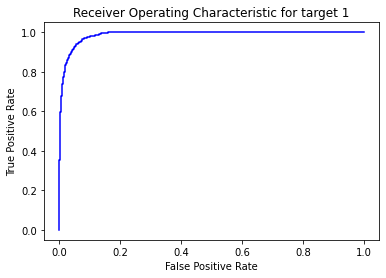

In [21]:
# plot ROC curve

fpr, tpr, threshold = metrics.roc_curve(Y, Y_pred)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic for target 1')
plt.plot(fpr, tpr, 'b')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
